<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Standardizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
from scipy import stats

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Mounted at /content/drive


In [5]:
import os
os.chdir("/content/drive/My Drive/Gaussianazing/")

In [6]:
ls

dble_pic.npy  example.ipynb  normalizing-flows/  wl_map.npy


# Use-case: Pixel values of a WL convergence map

In [9]:
data = np.load("wl_map.npy")

In [10]:
from matplotlib.colors import LogNorm

In [11]:
# make positive values
eps = 1e-5 # security value
cte = data.flatten().min() - 1e-5 # this usually is computed on the whole dataset if needed
x = data-cte

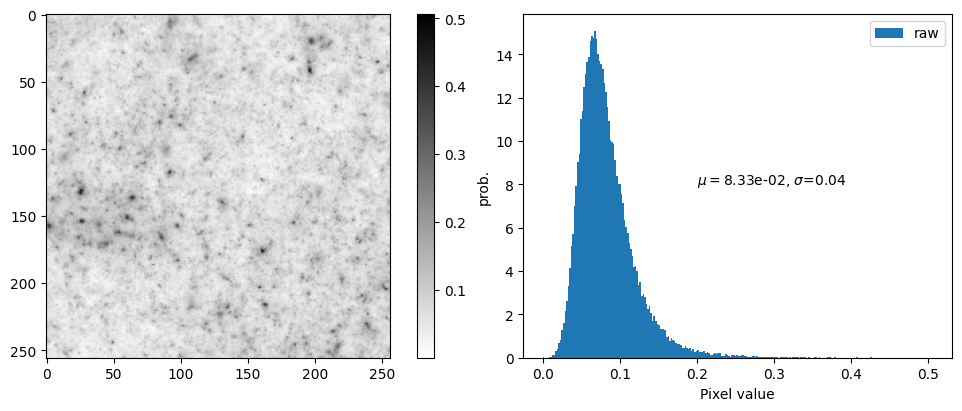

In [12]:
fig, ax = subplots(1,2, figsize=(10,4),layout="constrained")
img=ax[0].imshow(x,cmap="gray_r"); colorbar(img,ax=ax[0]);
ax[1].hist(x.flatten(),bins='auto', density=True, label="raw");
ax[1].set_xlabel("Pixel value");
ax[1].set_ylabel("prob.");
ax[1].legend();
ax[1].text(0.2,8.0,fr'$\mu =${x.mean():.2e}, $\sigma$={x.std():.2f}');

In [13]:
x = x.flatten() # to get a 1D distrib

## Usual standardization

In [14]:
#standardisation minimale
x_std_0 = (x-x.mean())/x.std()

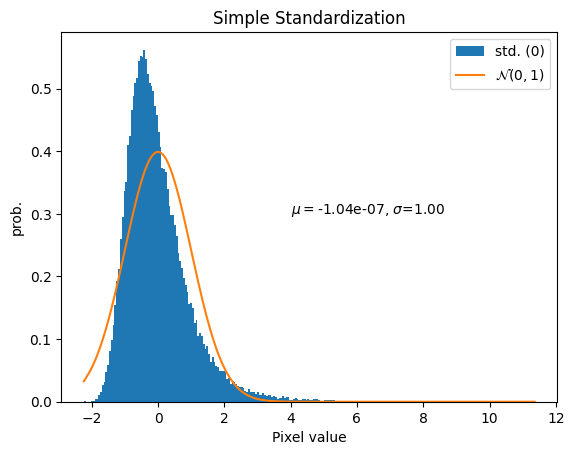

In [15]:
x_std_0.sort()
pdf_norm = stats.norm.pdf(x_std_0, 0.0, 1.0)

hist(x_std_0,bins='auto', density=True, label="std. (0)");
plot(x_std_0,pdf_norm,label=fr'$\mathcal{{N}}(0,1)$')

xlabel("Pixel value");
ylabel("prob.");
legend();
text(4,0.3,fr'$\mu =${x_std_0.mean():.2e}, $\sigma$={x_std_0.std():.2f}');
title("Simple Standardization");

Even if the sample mean $\mu$ and standard deviation $\sigma$ is (0,1) respectively, the pixel values usual standardization cannot give a normal distribution $\mathcal{N}(0,1)$ as the transformation is linear.

## Guess of the underlying distribution

One can use scipy to fit different tailed positive valuated distributions.

In [18]:
# fit lognormal distribution
x_val = np.array(sorted(x))
shape, loc, scale = stats.lognorm.fit(x_val, loc=0)
pdf_lognorm = stats.lognorm.pdf(x_val, shape, loc, scale)

# fit weibull distribution
shape, loc, scale = stats.weibull_min.fit(x_val, loc=0)
pdf_weibull = stats.weibull_min.pdf(x_val, shape, loc, scale)

# fit gamma distribution
shape, loc, scale = stats.gamma.fit(x_val, loc=0)
pdf_gamma = stats.gamma.pdf(x_val, shape, loc, scale)


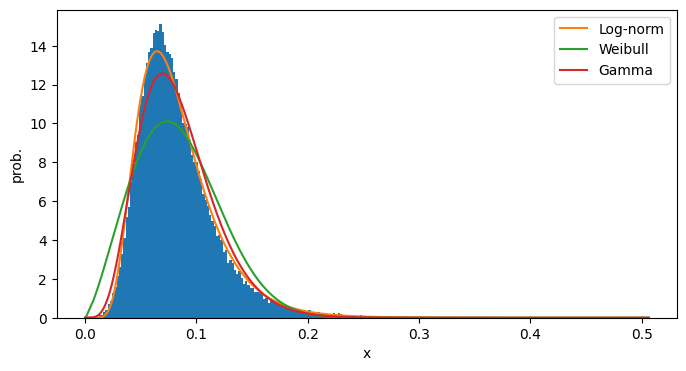

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(x_val, bins='auto', density=True)
ax.plot(x_val, pdf_lognorm, label='Log-norm')
ax.plot(x_val, pdf_weibull, label='Weibull')
ax.plot(x_val, pdf_gamma, label='Gamma')
ax.set_xlabel('x')
ax.set_ylabel('prob.')
ax.legend();
#ax.set_yscale('log')

Seems that in the use-case the distribution is quite close to the log-normal. We can then in this case apply a **log-transformation**.

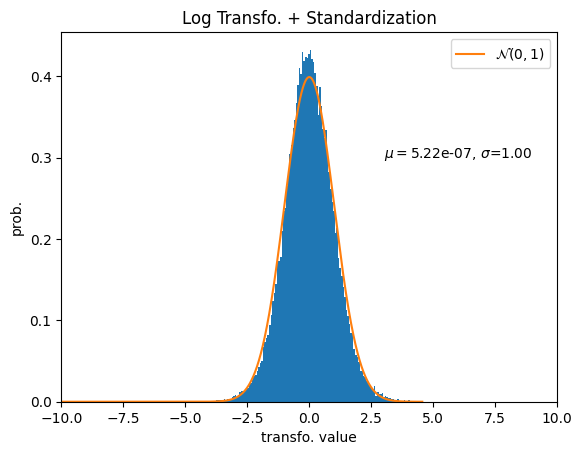

In [26]:
x_trans = np.log(x) # log-transformation.

x_val = (x_trans-x_trans.mean())/x_trans.std() # usual standardization

#Plot
x_val = np.array(sorted(x_val))
pdf_norm = stats.norm.pdf(x_val, 0.0, 1.0)
hist(x_val, bins='auto', density=True);
plot(x_val, pdf_norm, label=fr'$\mathcal{{N}}(0,1)$')
xlabel("transfo. value");
xlim([-10,10])
ylabel("prob.");
legend();
text(3,0.3,fr'$\mu =${x_val.mean():.2e}, $\sigma$={x_val.std():.2f}');
title("Log Transfo. + Standardization");

## Apply Box-Cox transform using scipy

Well, it may be that our use-case id a bit special, so let say that we do not guess what is the underlaying distribution. There is a paper by G. E. P. Box (1919-2013) D. R. Cox (1924-2022) two very well-known british statisticians, that described a simple transformation that help routine gaussianization.

[G. E. P. Box, D. R. Cox, An Analysis of Transformations, Journal of the Royal Statistical Society. Series B (Methodological), Vol. 26, No. 2. (1964), pp.211-252](https://www.ime.usp.br/~abe/lista/pdfQWaCMboK68.pdf)

The transformation is an exponentiation
$$
y = \begin{cases}
\frac{x^\lambda-1}{\lambda}  & \lambda \neq 0 \\
\log(x) & \lambda=0
\end{cases}
$$

The optimum $\lambda$ is obtained by minimizing the neagtive log-likelihood
$$
\ell(\lambda) = -(\lambda - 1) \sum_{i=1}^N\log(x_i) +
              \frac{N}{2} \log(Var(y_i)),
$$
with $Var(y_i)$ the sample variance of the $(y_i)_{i=1,N}$ using the transformation formula depending on the $\lambda$ value.

In [33]:
lmbda = stats.boxcox_normmax(x, method='mle')  # nb we can have a look the commented source to tune the search. default range lambda in (-2,2)

Best lambda parameter = 0.055


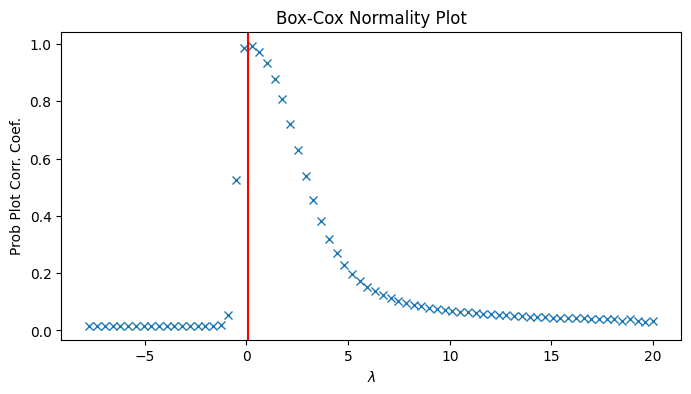

In [35]:
print('Best lambda parameter = %s' % round(lmbda, 3))

fig, ax = plt.subplots(figsize=(8, 4))
prob = stats.boxcox_normplot(x, -10, 20, plot=ax)
ax.axvline(lmbda, color='r');

Notice that the prefered $\lambda$ value is very close to 0, which is consistent with our log-normal guess. But, to be general

In [37]:
#The Box-Cox transformation
x_trans = (x**lmbda - 1)/lmbda

In [39]:
x_trans.mean(),x_trans.std()

(-2.3936148, 0.35983023)

In [40]:
#usual standardization
x_val = (x_trans-x_trans.mean())/x_trans.std()

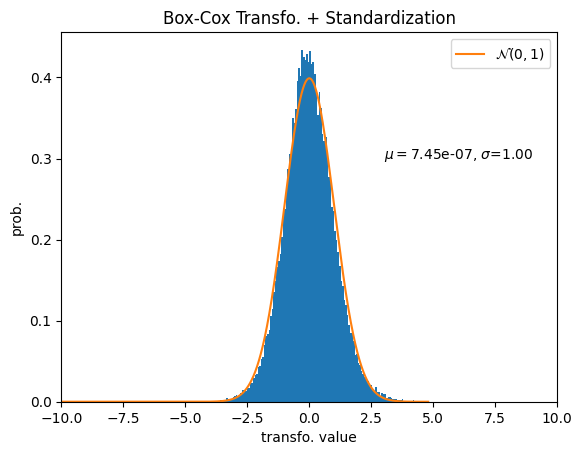

In [42]:
#Plot
x_val = np.array(sorted(x_val))
pdf_norm = stats.norm.pdf(x_val, 0.0, 1.0)
hist(x_val, bins='auto', density=True);
plot(x_val, pdf_norm, label=fr'$\mathcal{{N}}(0,1)$')
xlabel("transfo. value");
xlim([-10,10])
ylabel("prob.");
legend();
text(3,0.3,fr'$\mu =${x_val.mean():.2e}, $\sigma$={x_val.std():.2f}');
title("Box-Cox Transfo. + Standardization");

So, one finally get a gaussian (normal) distribution w/o the need to guess the distribution. As a one-line code one can use blindly

`x_norm, lmbda = stats.boxcox(x)`

# But... what about a multi-modal distribution?

In [7]:
x = np.load("dble_pic.npy")

In [8]:
np.random.shuffle(x) # just in case one want to split training/testing sets...

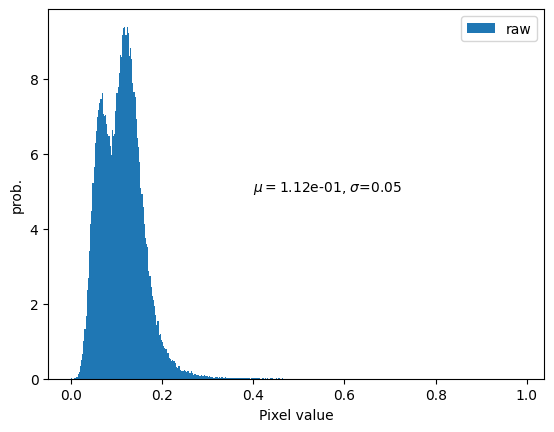

In [9]:
hist(x,bins='auto', density=True, label="raw");
xlabel("Pixel value");
ylabel("prob.");
legend();
text(0.4,5.0,fr'$\mu =${x.mean():.2e}, $\sigma$={x.std():.2f}');

In [10]:
x_norm, lmbda = stats.boxcox(x)

In [11]:
x_val = (x_norm-x_norm.mean())/x_norm.std()

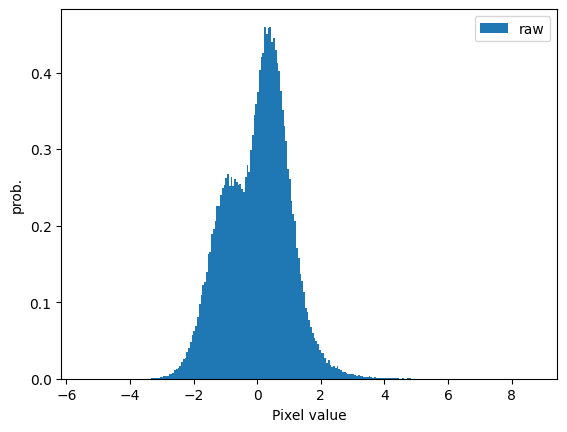

In [12]:
hist(x_val,bins='auto', density=True, label="raw");
xlabel("Pixel value");
ylabel("prob.");
legend();


No miracle! The Box-Cox transformation is not able to transform the double peaks distribution int a normal distribution...

## Normalizing Flow

A Pytorch implementation

In [42]:
!rm -rf './normalizing-flows/'
!git clone 'https://github.com/Baukebrenninkmeijer/normalizing-flows.git' './normalizing-flows/'

Cloning into './normalizing-flows'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 184 (delta 7), reused 6 (delta 6), pack-reused 173
Receiving objects: 100% (184/184), 697.82 KiB | 9.83 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [43]:
ls normalizing-flows

examples/  LICENSE  Makefile  nf/  READMATH.md  README.md  svgs/


In [44]:
path = '/content/drive/My Drive/Gaussianazing/'
sys.path.append(os.path.abspath(path+'normalizing-flows'))


In [45]:
from nf.flows import *
from nf.models import NormalizingFlowModel

In [46]:
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [140]:
flow = NSF_AR  # Auto Regressive Neural Spline Flow   (nb. MAF does not work)
nflows = 2
flows = [flow(dim=1) for _ in range(nflows)]

In [141]:
prior = MultivariateNormal(torch.zeros(1).to(device), torch.eye(1).to(device))
model = NormalizingFlowModel(prior, flows).to(device)

In [142]:
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [143]:
x_t = torch.tensor(x).to(device).to(torch.float32)

In [144]:
mean,std = x_t.mean(), x_t.std()

In [145]:
x_t = (x_t-mean)/std

In [146]:
x_t = x_t[:,None]

In [147]:
for i in range(500):
    optimizer.zero_grad()
    z, prior_logprob, log_det = model(x_t)
    logprob = prior_logprob + log_det
    loss = -torch.mean(prior_logprob + log_det)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Iter: {i}\t" +
                        f"Logprob: {logprob.mean().data:.2f}\t" +
                        f"Prior: {prior_logprob.mean().data:.2f}\t" +
                        f"LogDet: {log_det.mean().data:.2f}")


Iter: 0	Logprob: -2.37	Prior: -2.07	LogDet: -0.30
Iter: 100	Logprob: -1.40	Prior: -1.41	LogDet: 0.01
Iter: 200	Logprob: -1.39	Prior: -1.45	LogDet: 0.07
Iter: 300	Logprob: -1.38	Prior: -1.47	LogDet: 0.08
Iter: 400	Logprob: -1.38	Prior: -1.47	LogDet: 0.09


In [148]:
x_val = np.array(sorted(z[:,0].cpu().detach())) # the sort is just to plot correctly pdf
pdf_norm = stats.norm.pdf(x_val, 0.0, 1.0)


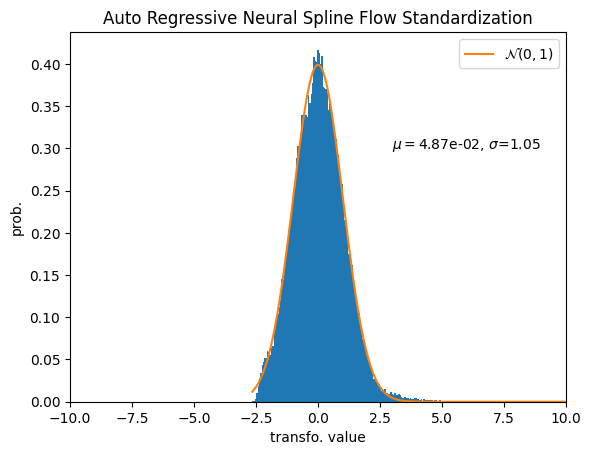

In [149]:
hist(x_val, bins='auto', density=True);
plot(x_val, pdf_norm, label=fr'$\mathcal{{N}}(0,1)$')
xlabel("transfo. value");
xlim([-10,10])
ylabel("prob.");
legend();
text(3,0.3,fr'$\mu =${x_val.mean():.2e}, $\sigma$={x_val.std():.2f}');
title("Auto Regressive Neural Spline Flow Standardization");